<a href="https://colab.research.google.com/github/emrunali/Codon_Usage_Clustermap/blob/main/123B_Source_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install biopython

In [9]:
from Bio import Entrez, SeqIO
from Bio.Seq import CodonTable
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Enter comma-separated accession numbers: U00096.3, CP021507.1, CP027540.1
Enter the codon table ID (1-33): 11


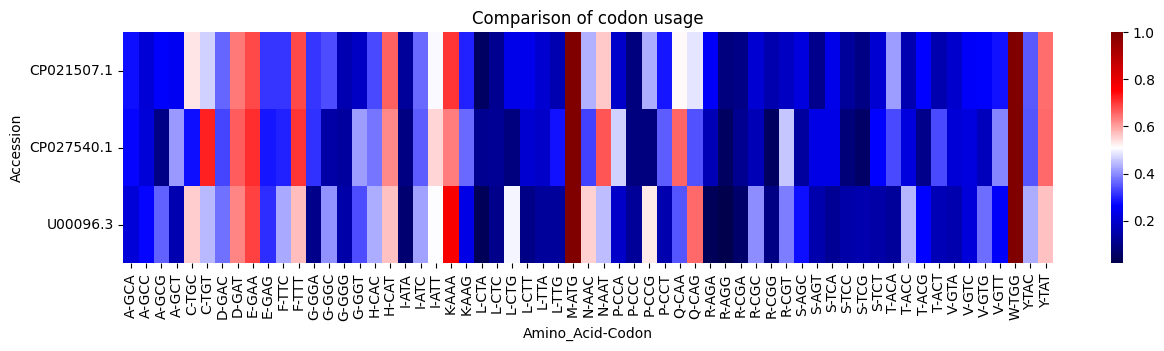

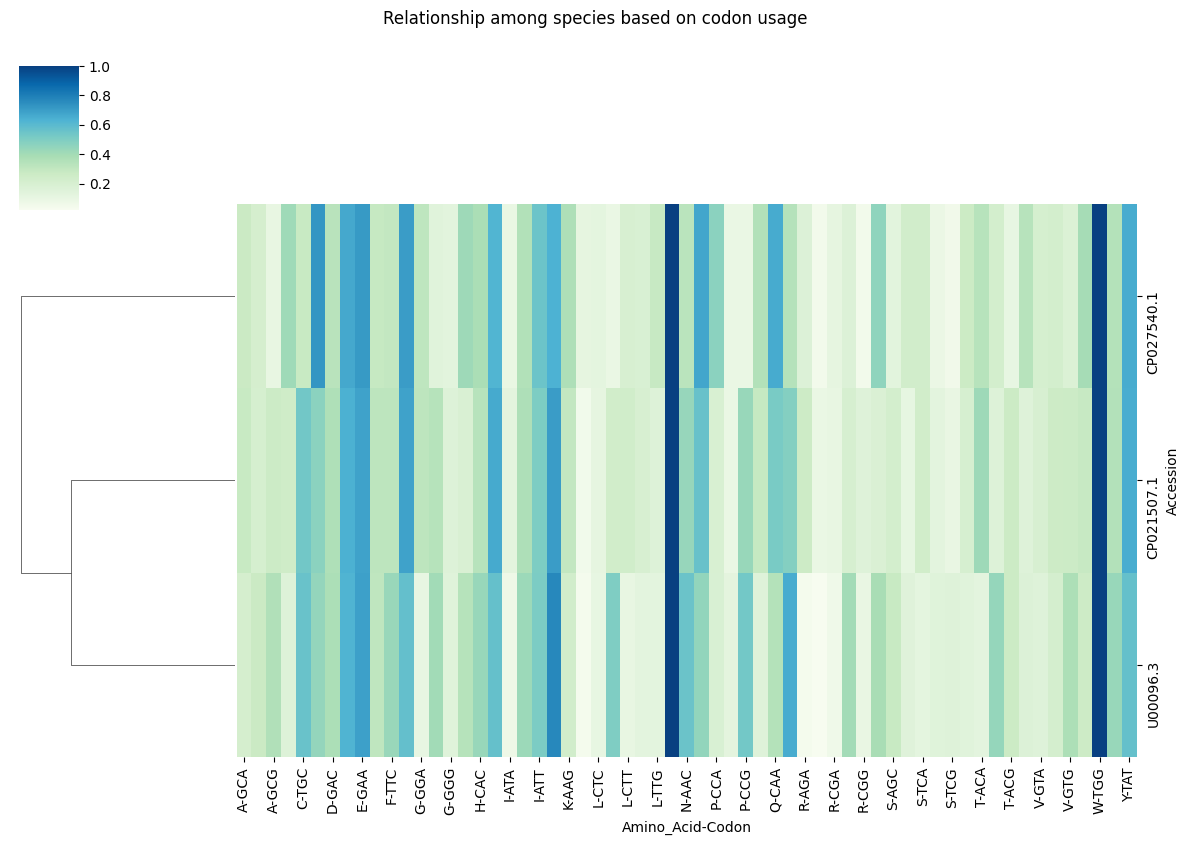

In [10]:
def get_cod_freq(cds_features, genetic_code_table):
    """ cds_features: list of CDS features
        genetic_code_table: Bio.Seq.CodonTable object
        Returns a dataframe of total absolute codon frequencies
    """

    codon_count = dict()

    for codon in genetic_code_table.forward_table:
        codon_count[codon] = 0  # dictionary to accumulate codon count

    stop_codons = {'TGA', 'TAG', 'TAA'}

    for cds_feature in cds_features:
        cds_seq = str(cds_feature.extract(record.seq)).upper()
        codons = [cds_seq[i:i+3] for i in range(0, len(cds_seq), 3) if 'N' not in cds_seq[i:i+3] and len(cds_seq[i:i+3]) == 3 and cds_seq[i:i+3] not in stop_codons]

        for codon in codons:
            codon_count[codon] += 1

    df_codcount = pd.DataFrame(list(codon_count.items()))
    df_codcount.columns = ['Codon', 'Obs_Freq']
    df_codcount['Amino_Acid'] = [genetic_code_table.forward_table.get(codon, '') for codon in df_codcount['Codon'].values]

    return df_codcount

def compute_relative_freq(df_codcount):
    """ Computes the relative frequency of each codon for each amino acid """

    df_codcount['Total_Freq'] = df_codcount.groupby('Amino_Acid')['Obs_Freq'].transform('sum')
    df_codcount['Relative_Freq'] = df_codcount['Obs_Freq'] / df_codcount['Total_Freq']

    return df_codcount

def get_optimal_codons(df_codcount):
    """ Indicates the optimal codon for each amino acid"""

    aa = compute_relative_freq(df_codcount)['Amino_Acid'].unique()
    aa_groups = compute_relative_freq(df_codcount).groupby('Amino_Acid')
    df_list = []

    for a in aa:
        d = aa_groups.get_group(a).copy()  # Create a copy of the DataFrame
        d['optimal'] = False  # Initialize the 'optimal' column with False
        max_freq = d['Relative_Freq'].max()
        d.loc[d['Relative_Freq'] == max_freq, 'optimal'] = True
        df_list.append(d)

    return pd.concat(df_list)


def analyze_accession(accession, genetic_code_table):
    Entrez.email = 'emrunali@gmail.com'
    handle = Entrez.efetch(db='nucleotide', id=accession, rettype='gb', retmode='text')

    global record
    record = SeqIO.read(handle, "genbank")


    # Access CDS features
    cds_features = [feature for feature in record.features if feature.type == "CDS"]

    # Get codon frequencies
    df_codon_freq = get_cod_freq(cds_features, genetic_code_table)
    df_codon_freq = compute_relative_freq(df_codon_freq)
    df_codon_freq = get_optimal_codons(df_codon_freq)

    return df_codon_freq

def main(accession_list):

    # Allow the user to choose the genetic code table
    genetic_code_table_id = int(input("Enter the codon table ID (1-33): "))
    genetic_code_table = CodonTable.unambiguous_dna_by_id.get(genetic_code_table_id, CodonTable.unambiguous_dna_by_id[1])

    df_list = []

    for accession in accession_list:
        df_accession = analyze_accession(accession, genetic_code_table)
        df_list.append(df_accession)

    # Combine dataframes for each accession
    df_result = pd.concat(df_list, keys=accession_list, names=['Accession'])

    return df_result

accession_input = input("Enter comma-separated accession numbers: ")
accession_list = [acc.strip() for acc in accession_input.split(',')]
codon_usage_df = main(accession_list)

codon_usage_df.index = codon_usage_df.index.get_level_values('Accession')
codon_usage_df.reset_index()

codon_cluster= codon_usage_df.groupby(["Accession", "Codon", "Amino_Acid" ])["Relative_Freq"].first().unstack().unstack().dropna(axis=1, how='all')
plt.figure(figsize=(15,3))
sns.heatmap(codon_cluster, cmap="seismic")
plt.title("Comparison of codon usage");
plt.show()

g=sns.clustermap(
    codon_cluster,
    cmap="GnBu",
    col_cluster=False,
    figsize=(12,8),
)
g.fig.suptitle("Relationship among species based on codon usage", y=1.05);